In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cProfile
import time
import math
%matplotlib inline

from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
from pprint import pprint

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
######################
# START OF VALID CODE
######################

In [5]:
# import 70,000 MNIST records from OpenML
from sklearn.datasets import fetch_openml
mnist_data = fetch_openml('mnist_784', version=1, cache=True)

In [4]:
# show what is in the data package
print(mnist_data.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [6]:
# extract data and labels
X = mnist_data.data
y = mnist_data.target

In [7]:
# show data shapes
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [8]:
# divide data into train and test splits
X_train, X_test = train_test_split(X, test_size=0.2, random_state=25)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=25)
# print('Train Data: ', X_train, '\n', 'Test Data:', X_test, '\n', 'Train label: ', y_train, '\n', 'Test Label: ', y_test)

In [8]:
df = pd.DataFrame(X_train)
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
60520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# initialize RFC with hyperparameters and run cross_val_score
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# produces [0.96741071, 0.96464286, 0.96830357, 0.96607143, 0.96491071] on 5 test folds and 0.9689 score
# %prun cProfile.run(cross_val_score(rf_clf, X_train, y_train, cv=3, scoring='accuracy'))\

start_time = time.time()
cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy')
end_time = time.time()
print("Elapsed time is {}".format(end_time-start_time))

In [142]:
score = rf_clf.score(X_test, y_test)
score

0.9710714285714286

In [160]:
# produces on 10 test folds and
# start_time = time.time()
# cross_val_score(rf_clf, X_train, y_train, cv=10, scoring='accuracy')
# end_time = time.time()
# print("Elapsed time is {}".format(end_time-start_time))

Elapsed time is 300.6270971298218


In [161]:
# score = rf_clf.score(X_test, y_test)
# score

0.9710714285714286

In [164]:
y_train_pred = cross_val_predict(rf_clf, X_train, y_train)

In [178]:
heatmap = confusion_matrix(y_train, y_train_pred)
row_sums = heatmap.sum(axis = 1, keepdims = True)
heatmap_normal = heatmap/row_sums
np.fill_diagonal(heatmap_normal, 0)

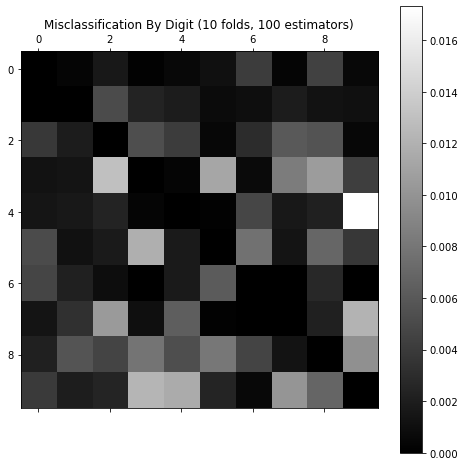

In [183]:
# generate heatmap showing where majority of errors are occurring (ex: 4 is mistaken for 9 most frequently)
plt.figure(figsize=(8,8))
plt.matshow(heatmap_normal, fignum=1, cmap = plt.cm.gray)
plt.title('Misclassification By Digit (10 folds, 100 estimators)')
plt.colorbar()
plt.show()

In [185]:
pprint(rf_clf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [11]:
# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use n-1 cores
start_time = time.time()
rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = 7)# Fit the random search model
rf_random.fit(X_train, y_train)
end_time = time.time()
print("Elapsed time is {}".format(end_time-start_time))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Elapsed time is 2287.3885490894318


In [12]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

In [16]:
# refit using best params
rf_clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_depth=60, bootstrap=False)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=60, min_samples_leaf=2)

In [17]:
start_time = time.time()
cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy')
end_time = time.time()
print("Elapsed time is {}".format(end_time-start_time))

Elapsed time is 199.09338331222534


In [18]:
score = rf_clf.score(X_test, y_test)
score

0.9722857142857143